In [1]:
import os
os.chdir(os.path.pardir)

In [2]:
from utilities import *

In [7]:
data_path = "../data/dataset_corridor_85"

52940

In [ ]:
# split in train/test?

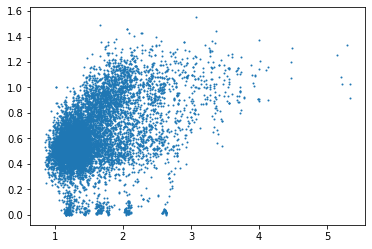

Epoch 1/50
313/313 - 4s - loss: 0.0530 - 4s/epoch - 11ms/step
Epoch 2/50
313/313 - 4s - loss: 0.0490 - 4s/epoch - 12ms/step
Epoch 3/50
313/313 - 4s - loss: 0.0485 - 4s/epoch - 13ms/step
Epoch 4/50
313/313 - 5s - loss: 0.0483 - 5s/epoch - 16ms/step
Epoch 5/50
313/313 - 5s - loss: 0.0481 - 5s/epoch - 17ms/step
Epoch 6/50
313/313 - 6s - loss: 0.0480 - 6s/epoch - 18ms/step
Epoch 7/50
313/313 - 7s - loss: 0.0480 - 7s/epoch - 21ms/step
Epoch 8/50
313/313 - 7s - loss: 0.0479 - 7s/epoch - 23ms/step
Epoch 9/50
313/313 - 8s - loss: 0.0479 - 8s/epoch - 25ms/step
Epoch 10/50
313/313 - 8s - loss: 0.0478 - 8s/epoch - 26ms/step
Epoch 11/50
313/313 - 9s - loss: 0.0478 - 9s/epoch - 29ms/step
Epoch 12/50
313/313 - 10s - loss: 0.0478 - 10s/epoch - 30ms/step
Epoch 13/50
313/313 - 10s - loss: 0.0478 - 10s/epoch - 32ms/step
Epoch 14/50
313/313 - 11s - loss: 0.0478 - 11s/epoch - 35ms/step
Epoch 15/50
313/313 - 11s - loss: 0.0477 - 11s/epoch - 36ms/step
Epoch 16/50
313/313 - 12s - loss: 0.0478 - 12s/epoch - 3

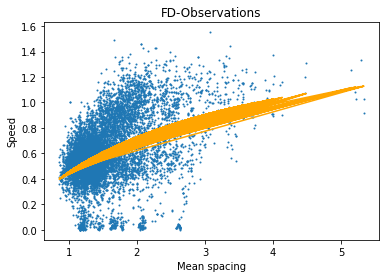

In [8]:
fd_data, fd_targets = read_dataset(data_path, fd_training=True)
indexes = np.arange(len(fd_data))
indexes = np.random.choice(indexes, size=10000, replace=True)
fd_data = fd_data[indexes]
fd_targets = fd_targets[indexes]

plt.scatter(fd_data, fd_targets, s=1)  # original data
plt.show()

# to stop the computation when model is at its cap
callback = EarlyStopping(monitor='loss', patience=10)  # default on val_loss

# train the FD model
model = FD_Network()
model.compile(optimizer='adam', loss='mse', run_eagerly=True)
model.fit(x=fd_data, y=fd_targets, epochs=50, verbose=2, callbacks=[callback])

# generate the FD speeds with prediction
mean_spacings = fd_data
fd_speeds = model.predict(x=mean_spacings)
model.mse = np.mean((fd_speeds-fd_targets)**2)


# plot the FD prediction over the observations
plt.scatter(fd_data, fd_targets, s=1)  # original data
plt.scatter(mean_spacings, fd_speeds, c='orange', s=1)  # fd model data
plt.xlabel("Mean spacing")
plt.ylabel("Speed")
plt.title("FD-Observations")
plt.show()

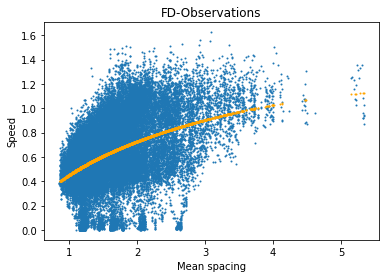

In [10]:
# plot the FD prediction over the observations
plt.scatter(fd_data, fd_targets, s=1)  # original data
plt.scatter(mean_spacings, fd_speeds, c='orange', s=1)  # fd model data
plt.xlabel("Mean spacing")
plt.ylabel("Speed")
plt.title("FD-Observations")
plt.show()

In [14]:
fd_data, fd_targets = read_dataset(data_path, fd_training=True)
nn_data, nn_targets = read_dataset(data_path, fd_training=False)


# to stop the computation when model is at its cap
callback = EarlyStopping(monitor='loss', patience=10)  # default on val_loss

hidden_dims = (3,)

# train the speed predictor neural network
print("Training the NN model..")
nn = create_nn(hidden_dims, dropout=-1)
nn.compile(optimizer='adam', loss='mse')
hist = nn.fit(x=nn_data, y=nn_targets, epochs=1000, callbacks=[callback], verbose=1)
loss_nn = hist.history['loss']

# create the speed for FD to learn
nn_speeds = nn.predict(x=nn_data)

# train the FD model
print("Training the FD model..")
fd_data = fd_data[indexes]
nn_speeds = nn_speeds[indexes]
model2 = FD_Network()
model2.compile(optimizer='adam', loss='mse', run_eagerly=True)
hist = model2.fit(x=fd_data, y=nn_speeds, epochs=50, callbacks=[callback], verbose=1)
loss_fd = hist.history['loss']

# training plots
if training_plots:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    # FD
    ax[0].plot(loss_fd)
    ax[0].set_title("FD training")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("MSE")
    # NN
    ax[1].plot(loss_nn, c='red')
    ax[1].set_title("NN training")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("MSE")
    fig.show()

# plot
mean_spacings = fd_data
fd_speeds = model2.predict(x=mean_spacings)
fig, ax = plt.subplots(1, 1)
ax.plot(mean_spacings, fd_speeds, c='orange')
ax.scatter(nn_data[:, 0], nn_speeds, s=1, c='red')
ax.set_xlabel("Mean spacing")
ax.set_ylabel("Speed")
# fig.suptitle("")
plt.show()

Training the NN model..
Epoch 1/1000
1655/1655 [==============================] - 2s 885us/step - loss: 0.1505 0s - loss: 
Epoch 2/1000
1655/1655 [==============================] - 1s 783us/step - loss: 0.0497
Epoch 3/1000
1655/1655 [==============================] - 1s 755us/step - loss: 0.0427
Epoch 4/1000
1655/1655 [==============================] - 1s 773us/step - loss: 0.0373
Epoch 5/1000
1655/1655 [==============================] - 1s 811us/step - loss: 0.0351
Epoch 6/1000
1655/1655 [==============================] - 1s 761us/step - loss: 0.0342
Epoch 7/1000
1655/1655 [==============================] - 1s 771us/step - loss: 0.0339 0
Epoch 8/1000
1655/1655 [==============================] - 1s 735us/step - loss: 0.0337
Epoch 9/1000
1655/1655 [==============================] - 1s 755us/step - loss: 0.0336
Epoch 10/1000
1655/1655 [==============================] - 1s 752us/step - loss: 0.0334
Epoch 11/1000
1655/1655 [==============================] - 1s 744us/step - loss: 0.0333
Epo

1655/1655 [==============================] - 1s 803us/step - loss: 0.0323
Epoch 94/1000
1655/1655 [==============================] - 1s 823us/step - loss: 0.0322
Epoch 95/1000
1655/1655 [==============================] - 1s 823us/step - loss: 0.0322
Epoch 96/1000
1655/1655 [==============================] - 1s 799us/step - loss: 0.0322
Epoch 97/1000
1655/1655 [==============================] - 1s 770us/step - loss: 0.0322
Epoch 98/1000
1655/1655 [==============================] - 1s 786us/step - loss: 0.0322
Epoch 99/1000
1655/1655 [==============================] - 1s 768us/step - loss: 0.0322
Epoch 100/1000
1655/1655 [==============================] - 1s 767us/step - loss: 0.0322
Epoch 101/1000
1655/1655 [==============================] - 1s 744us/step - loss: 0.0322
Epoch 102/1000
1655/1655 [==============================] - 1s 747us/step - loss: 0.0322
Epoch 103/1000
1655/1655 [==============================] - 1s 729us/step - loss: 0.0322
Epoch 104/1000
1655/1655 [================

1655/1655 [==============================] - 1s 741us/step - loss: 0.0319
Epoch 185/1000
1655/1655 [==============================] - 1s 708us/step - loss: 0.0319
Epoch 186/1000
1655/1655 [==============================] - 1s 726us/step - loss: 0.0319
Epoch 187/1000
1655/1655 [==============================] - 1s 764us/step - loss: 0.0319
Epoch 188/1000
1655/1655 [==============================] - 1s 727us/step - loss: 0.0319
Epoch 189/1000
1655/1655 [==============================] - 1s 715us/step - loss: 0.0319
Epoch 190/1000
1655/1655 [==============================] - 1s 733us/step - loss: 0.0319
Epoch 191/1000
1655/1655 [==============================] - 1s 742us/step - loss: 0.0319
Epoch 192/1000
1655/1655 [==============================] - 1s 722us/step - loss: 0.0318
Epoch 193/1000
1655/1655 [==============================] - 1s 745us/step - loss: 0.0319
Epoch 194/1000
1655/1655 [==============================] - 1s 752us/step - loss: 0.0319
Epoch 195/1000
1655/1655 [==========

TypeError: fit() got an unexpected keyword argument 'run_eagerly'